# Sentiment Analysis

---

Business Problem: You are working at Foods Inc as a data analyst. The company is a chain of sophisticated restaurants in Brazil and is expanding rapidly, also operating in the Uruguay and Paraguay segments.
The company is currently in the process of modernizing technologies and processes, the company's main focus now is to target customers and products, one of the company's biggest updates is the creation of an online application that works like an "online restaurant", the customer Create an account on the app and order food, after that the restaurant creates food and sends it to the customer's home.
A very simple e-commerce, but for food.
By creating an account, customers can order any type of food available from restaurants near their location. After that, the restaurant creates the order and delivery the food to the customer location, the customer can provide post delivery feedback and a star rating.
This application has been running for a year and the company has collected some raw data and now its challenge is to provide insights with this data set.
One of the main objectives is to create an estimator that works as a validator of sentiment scores.
If the score is 5 and the text is "very bad", you will need to confirm this score with an estimator.

In this small project I aim to train my skills with Spark on multiclass classification problems.

The project basically consists of sentiment analysis pipeline using kaggle dataset product reviews on this link: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews.

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Dataset Overview:

- *Id*: Row Number.
- *ProductId*: Product that customer buy at a restaurant.
- *UserId*: Customer indentification.
- *ProfileName*: Customer Profile.
- *Time*: Feedback timestamp.
- *HelpfulnessNumerator|HelpfulnessDenominator*: Indicators.
- *Score*: Sentiment.
- *Summary*: A summary of text.
- *Text*: Customer feedback.

## 0.0. Requirements

### 0.1. Imports

In [1]:
#import mlflow
import numpy as np
import pandas as pd

import seaborn as sns 
from matplotlib import pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql import functions as pf

from pyspark.sql.types import FloatType
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.utils import AnalysisException

from pyspark.ml import Pipeline
from pyspark.ml import Transformer

from pyspark.ml.feature import (
    IDF,
    IDFModel,
    Tokenizer,
    HashingTF,
    StopWordsRemover,
    VectorAssembler
)

from pyspark.ml.classification import LogisticRegression

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sentence_transformers import SentenceTransformer

/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2. Aux Functions

In [2]:
spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory", "10g") \
        .config("spark.executor.memory", "10g") \
        .getOrCreate()

sc = spark.sparkContext

sc

24/06/06 22:05:30 WARN Utils: Your hostname, grc resolves to a loopback address: 127.0.1.1; using 192.168.3.7 instead (on interface eno1)
24/06/06 22:05:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/06 22:05:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
class NoiseLableRemoval(Transformer):
    """
    This class is responsible for filtering wrong Scores
    and for create label class associated with the scores.

    inputs:
        - inputCol: Column that will be transformed.
        - outputCol: Output Column name.
        - labelCol: Label / Score column to generate Bad, Neutral or Good label.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        inputCol: str = "Text",
        outputCol: str = "Text",
        labelCol: str = "Score"
    ):

        self.inputCol = inputCol
        self.outputCol = outputCol
        self.labelCol = labelCol

    # Transform
    def _transform(self, dataset: DataFrame) -> DataFrame:
        y_col = self.labelCol
        
        if y_col not in dataset.columns:
            raise AnalysisException(f"'{y_col}' column not exists on DataFrame")

        # check consistent labels
        current_labels = [j[0] for j in dataset.select(pf.col(y_col)).distinct().collect()]
        current_labels.sort()

        if current_labels == [0, 1, 2]:
            return dataset

        else:
            df = dataset.filter(pf.col(y_col).isin([0, 1, 2, 3, 4, 5]))

            # Good, Neutral and Bad
            df = df.withColumn(
                y_col,
                pf.when(pf.col(y_col) < 2, 0) \
                .when((pf.col(y_col) >= 2) & (pf.col(y_col) < 4), 1) \
                .when(pf.col(y_col) >= 4, 2)
            )

            return df
    
class FilterRowsFeatures(Transformer):
    """
    This class is responsible for filtering rows and columns in dataset.

    inputs:
        - aggCols: Columns to Agg and Keep.
        - keyCol: Column to be unique key.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        aggCols: list,
        keyCol: str = "Id"
    ):
        self.aggCols = aggCols
        self.keyCol = keyCol

    def _transform(self, dataset: DataFrame) -> DataFrame:
        df_filter = dataset.groupBy(self.aggCols).agg(pf.max(pf.col(self.keyCol)).alias(self.keyCol))
        df_filter = df_filter.select([self.keyCol] + self.aggCols)

        return df_filter
    
    
class CleanCorpus(Transformer):
    """
    This class is responsible for cleaning text columns with SQL and Regex in a given dataset.

    inputs:
        - cleanCols: Columns to be cleaned with SQL and Regex.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        cleanCols: list
    ):
        self.cleanCols = cleanCols

    def _transform(self, dataset: DataFrame) -> DataFrame:
        df_clean = dataset

        for col in self.cleanCols:
            df_clean = df_clean.withColumn(
                col,
                pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.trim(pf.lower(pf.regexp_replace(pf.col(col), '-', ''))), r'[.,]+', '. '), r'<[^>]+>', " "), r'\(.+?\)', ''), '"', ''), r'\s+', " "), ":", "").alias(col)
            )

        return df_clean
    
class FeatureEngineering(Transformer):
    """
    This class is responsible for feature engineering in a given dataset.

    inputs:
        - dummyCol: Do Nothing.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        dummyCol: str = "dummyCol"
    ):
        self.dummyCol = dummyCol

    def _transform(self, dataset: DataFrame) -> DataFrame:
        df_features = dataset

        # Summary + Text feature
        df_features = df_features.withColumn(
            "Text",
            pf.regexp_replace(pf.concat_ws(" ", pf.col("Summary"), pf.col("Text")), r"\s+", " ")
        ).drop("Summary")

        return df_features

In [38]:
def undersampling_dataframe(
    df: DataFrame,
    minority_class_sample: int = 33000,
    labels: list = [0, 1, 2]
) -> DataFrame:
    """
    Slice Top K rows from a PySpark dataframe for each input labels.
    
    inputs:
        - df: Base DataFrame for slice.
        - minority_class_sample: Top K int values for slice.
        - labels: list of label for split into split_size samples.

    returns:
        - df_samples: Base input DataFrame with Top K sliced samples.
    """
    df_samples = df.limit(1)

    for label in labels:
        # Filter classes
        df_filter_class = df.filter(pf.col("Score") == label).limit(minority_class_sample)

        # Union on df_samples reference
        df_samples = df_samples.select(df_filter_class.columns).unionAll(df_filter_class).distinct()

    df_samples = df_samples.filter(pf.col("Score").isin(labels))

    df_samples.groupBy("Score").count().orderBy("count").show()

    return df_samples

def build_preprocessing_pipeline():
    noise_score_removal = NoiseLableRemoval(
        inputCol="Text",
        outputCol="Text",
        labelCol="Score"
    )

    filter_rows_features = FilterRowsFeatures(
        aggCols=['ProductId', 'UserId', 'Score', 'ProfileName', 'Summary', 'Text'],
        keyCol="Id"
    )

    clean_corpus = CleanCorpus(
        cleanCols=['ProfileName', 'Text', 'Summary']
    )

    feature_engineering = FeatureEngineering()

    stages = [
        noise_score_removal,
        filter_rows_features,
        clean_corpus,
        feature_engineering
    ]

    return Pipeline(stages=stages)

In [5]:
def get_multiclass_metrics(
    df_predictions: DataFrame,
    y_col: str = "Score"
) -> MulticlassMetrics:
    """
    Get Spark MulticlassMetrics object.
    
    inputs:
        - df_predictions: DataFrame with Y and Yhat.
        - y_col: Y col name.

    returns:
        - df_predictions: Is simple a MulticlassMetrics object.
    
    """

    m = df_predictions.select(
        pf.col("prediction").cast(FloatType()).alias("prediction"),
        pf.col(y_col).cast(FloatType()).alias("label"),
    )

    m = m.rdd.map(tuple)

    m = MulticlassMetrics(m)

    return m

def get_ml_metrics(
    df_predictions: DataFrame,
    y_col: str = "Score",
    labels: list = [0, 1, 2],
    plot_confusion_matrix: bool = True
):
    """
    Gte Pyspark Geral multiclass metrics.
    
    inputs:
        - df_predictions: DataFrame with Y and Yhat.
        - y_col: Y col name.

    returns:
        - metrics dict: Dict with weight metrics.
    
    """
    m = get_multiclass_metrics(df_predictions, y_col)

    acc = m.accuracy
    wre = m.weightedRecall
    wpr = m.weightedPrecision
    
    print(f"Accuracy: {acc:.4f}")
    print(f"W. Recall: {wre:.4f}")
    print(f"W. Precision: {wpr:.4f}\n")

    recs, precs = [], []
    for label in set(labels):
        p = m.precision(label)
        r = m.recall(label)
        recs.append(r)
        precs.append(p)

        print(f"Label: {label}, Recall: {p:.4f}")
        print(f"Label: {label}, Precision: {r:.4f}\n")
    
    srec = sum(recs) / 3
    spre = sum(precs) / 3
    print(f"Mean Recalls: {srec:.4f}, Mean Precisions: {spre:.4f}\n\n")

    if plot_confusion_matrix:
        fig, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(m.confusionMatrix().toArray(), cmap="Blues", annot=True, fmt="g", linewidths=0.5, linecolor="k", ax=ax)
        ax.set_title("Confusion Matrix")
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label");

    return {
        "accuracy": acc,
        "wprecision": wpr,
        "wrecall": wre,
        "mrec": srec,
        "mprec": spre
    }

## 1.0. Dataset Balance

Given the new challenges facing imbalanced learning, extensive efforts and significant progress have been made in the community to tackle this problem.

Sampling methods seem to be the dominate type of approach in the community as they tackle imbalanced learning in a straightforward manner. In general, the use of sampling methods in imbalanced learning consists of the modification of an imbalanced dataset by some mechanism in order to provide a balanced distribution. Representative work in this area includes random oversampling, random undersampling, synthetic sampling with data generation, cluster-based sampling methods, and integration of sampling and boosting.

The key aspect of sampling methods is the mechanism used to sample the original dataset. Under different assumptions and with different objective considerations, various approaches have been proposed. For instance, the mechanism of random oversampling follows naturally from its description by replicating a randomly selected set of examples from the minority class. On the basis of such simple sampling techniques, many informed sampling methods have been proposed, such as the EasyEnsemble and BalanceCascade algorithms. Synthetic sampling with data generation techniques has also attracted much attention.

For example, the synthetic minority oversampling technique (SMOTE) algorithm creates artificial data based on the feature space similarities between existing minority examples. Adaptive sampling methods have also been proposed, such as the borderline-SMOTE and adaptive synthetic (ADASYN) sampling algorithms. Sampling strategies have also been integrated with ensemble learning techniques by the community, such as in SMOTEBoost, RAMOBoost, and DataBoost-IM. Data-cleaning techniques, such as Tomek links, have been effectively applied to remove the overlapping that is introduced from sampling methods for imbalanced learning. Some representative work in this area includes the one-side selection (OSS) methos and the neighborhood cleaning rule (NCL).

Another approach is a Cost-sensitive learning methods target the problem of imbalanced learning by using different cost matrices that describe the costs for misclassifying any particular data example. Research in the past indicates that there is a strong connection between cost-sensitive learning and imbalanced learning. In general, there are three categories of approaches to implement cost-sensitive learning for imbalanced data.
- The first class of techniques applies misclassification costs to the dataset as a form of dataspace weighting (translation theorem); these techniques are essentially cost-sensitive bootstrap sampling approaches where misclassification costs are used to select the best training distribution.
- The second class applies cost-minimizing techniques to the combination schemes of ensemble methods (Metacost framework); this class consists of various meta techniques, such as the AdaC1, AdaC2, and AdaC3 method and AdaCost.
- The third class of techniques incorporates costsensitive functions or features directly into classification paradigms to essentially "fit" the cost-sensitive framework into these classifiers, such as the cost-sensitive decision trees, cost-sensitive neural networks, cost-sensitive Bayesian classifiers, and cost-sensitive support vector machines (SVMs).

Exists other methods and estimators, but this two is the most basic and fundamentals. The first (Sampling methods), most precise Under Sampling is my choise for working with this dataset, because i cannot create random sampling from text wuthout using embeddings or any other type of mechanism for work with this. I selected undersampling because is the most simple, faster and reproductibility method.

I will consider two main datasets for testing the performance of both, a balanced dataset and a umbalanced dataset.

In [36]:
df = spark.read.format("parquet").load("../data/train")

df.groupBy("Score").count().show()

+-----+------+
|Score| count|
+-----+------+
|    1| 47297|
|    2|292387|
|    0| 33423|
+-----+------+



In [46]:
labels = [k[0] for k in df.select(pf.col("score")).distinct().collect()]
minority_class_sample = df.groupBy("Score").count().orderBy("count").limit(1).select("count").collect()[0][0]

print(f"Labels: {labels}, with {minority_class_sample} samples.")

Labels: [1, 2, 0], with 33423 samples.


In [39]:
df_sample = undersampling_dataframe(df=df, minority_class_sample=minority_class_sample)

+-----+-----+
|Score|count|
+-----+-----+
|    1|33423|
|    2|33423|
|    0|33423|
+-----+-----+



In [140]:
df_sample.write.format("parquet").mode("overwrite").save("../data/train_undersampling")

## 2.0. Spark Pipeline

Before dive into Machine Learning, i need to replicate all transformations created in Train dataset into OOT and Test dataset, the steps is:

- Filtering Rows and Columns and Noisy (I Will remove duplciated rows from OOT and Test and apply feature selection).
- Cleaning Text (Clean text with basic SQL functions).
- Feature Engineering (Feature Engineering Step to combine text and summary).

To make the deployment script more simplified, I will use a Pyspark feature called Pipeline, it serves as a list of transformations that will then be applied until classification, for example, cleans, preparations, transformations and classification.

In [6]:
df_test = spark.read.format("parquet").load("../data/test")
df_oot = spark.read.format("parquet").load("../data/oot")

In [7]:
df_test.filter(pf.col("Id") == 4).show(truncate=False)

+---+----------+--------------+-----------+--------------------+----------------------+-----+-------------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |ProductId |UserId        |ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time               |Summary       |Text                                                                                                                                                                                                                       |
+---+----------+--------------+-----------+--------------------+----------------------+-----+-------------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
pipeline = build_preprocessing_pipeline()

pipeline = pipeline.fit(df_test)
df_test = pipeline.transform(df_test)
df_oot = pipeline.transform(df_oot)

df_test.filter(pf.col("Id") == 4).show(truncate=False)

+---+----------+--------------+-----+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |ProductId |UserId        |Score|ProfileName|Text                                                                                                                                                                                                                    |
+---+----------+--------------+-----+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|4  |B000UA0QIQ|A395BORC6FGVXV|1    |karl       |cough medicine if you are looking for the secret ingredient in robitussin i believe i have found it. i got this in addition to the root beer extract i

## 3.0. Machine Learning for Sentiment Analysis

In [53]:
df_train = spark.read.format("parquet").load("../data/train_undersampling")

In this step I will create two main solution.

A sentiment analysis with traditional machine learning using TF-IDF and a second solution with hugging face transformers embedding, afther feature extraction with TF-IDF and Embeddings I selected a Random Forest estimator to create probability Scores for each class of sentiment.

### 3.1. Classical Sentiment Analisys

#### 3.1.1. Tokenization

For classical TF-IDF solution, exists is another stages of processing and cleaning the data.

First I separate the strings into "tokens" which are nothing more than a vector of words, this vector is used in the next class we will use, which is StopWordsRemover which in short will remove the stopwords.

Examples of stopwords is: "to, it, a", is considered noisy data in nlp tasks.

You can see all example transformations on this dataset on a dataframe.show().

In [10]:
tokenizer = Tokenizer(inputCol="Text", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="words")

# I Will Save this version of tokenizer
# When I re-train the model, at this stage I can use a new version of the tokenizer.
# But, for now, i will fix this version.
#tokenizer.write().save("../src/features/tokenizer.spark")

In [11]:
df_train_tokens = stopwords.transform(tokenizer.transform(df_train))
df_test_tokens = stopwords.transform(tokenizer.transform(df_test))
df_oot_tokens = stopwords.transform(tokenizer.transform(df_oot))

In [12]:
# Stopwords tokens removed
df_train_tokens.show(3, truncate=False)

+----+----------+--------------+-----+---------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------

#### 3.1.2. TF-IDF

Now I need to take the text and transform into in a numerical vector.
In pyspark exists two tools to do that.

1. Word2Vec;
2. TF-IDF / HashingTF;

First i will try TF-IDF, before is a good test to switch to word2vec.

After the previous data cleaning, now is the step of applying some form of numerical representation of the textual data.
The most classic and simple is the TF-IDF tool which stands for "Term Frequency" and "Inverse Document Frequency".

IF-IDF is a sequence of steps, lets check:

**1. For the given documents**

Document 1: "monkey eats a banana" - Have "a" stopword in this document. 
Tokens: [monkey, eats, a, banana]

Document 2: "monkey like banana"
Tokens: [monkey, like, banana]

**2. Term Frequency (TF)**

Calculate the Term Frequency (TF) for each term in each document. The "TF" of a term in a document (Vector of tokens) is the number of times the term (t) appears in that document (d) divided by the total number of terms in the document (t / len( d ) ).

For Document 1:

TF(monkey) = 1/4

TF(eats) = 1/4

TF(a) = 1/4

TF(banana) = 1/4

For Document 2:

TF(monkey) = 1/3

TF(like) = 1/3

TF(banana) = 1/3


**3. Inverse Document Frequency (IDF)**

Calculate the Inverse Document Frequency (IDF) for each "term". IDF is next step to represent Term in other documents.
Total number of documents: (N) = 2

For each term:

IDF(monkey) = log(2 / 2 + 1) = log(2/3)

IDF(eats) = log(2 / 1 + 1) = log(2)

IDF(a) = log(2 / 1 + 1) = log(2)

IDF(banana) = log(2 / 2 + 1) = log(2/3)

IDF(like) = log(2 / 1 + 1) = log(2)


**4. TF-IDF Calculation**

Calculate the TF-IDF score for each term in each document by multiplying the TF and IDF values.

*For Document 1:*

TF-IDF(monkey) = TF(monkey) * IDF(monkey) = (1/4) * log(2/3)

TF-IDF(eats) = TF(eats) * IDF(eats) = (1/4) * log(2)

TF-IDF(a) = TF(a) * IDF(a) = (1/4) * log(2)

TF-IDF(banana) = TF(banana) * IDF(banana) = (1/4) * log(2/3)


*For Document 2:*

TF-IDF(monkey) = TF(monkey) * IDF(monkey) = (1/3) * log(2/3)

TF-IDF(like) = TF(like) * IDF(like) = (1/3) * log(2)

TF-IDF(banana) = TF(banana) * IDF(banana) = (1/3) * log(2/3)

Now, you have calculated the TF-IDF scores for each term in each document manually. These scores reflect the importance of each term within the respective documents and can be used for various text analysis tasks.
In this example we do not have same term multiple times on each document, but simple add more terms to change the formula results.

In pyspark exists "HashingTF", stands for:

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.HashingTF.html

"Maps a sequence of terms to their term frequencies using the hashing trick. Currently we use Austin Appleby’s MurmurHash 3 algorithm (MurmurHash3_x86_32) to calculate the hash code value for the term object. Since a simple modulo is used to transform the hash function to a column index, it is advisable to use a power of two as the numFeatures parameter; otherwise the features will not be mapped evenly to the columns."

The IDF Spark docs: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.feature.IDF.html

In [54]:
# NumFeatures is a Hyp. Param, I need to tune numFeatures in future for test model performance and find ideal number of features.
# A high number cause memory overflow in a low memory cluster of pyspark.

hashing = HashingTF(inputCol="words", outputCol="raw_features") #numFeatures=100_000
idf = IDF(inputCol="raw_features", outputCol="features")

In [14]:
idf = idf.fit(hashing.transform(df_train_tokens))

df_train_idf = idf.transform(hashing.transform(df_train_tokens))
df_test_idf = idf.transform(hashing.transform(df_test_tokens))
df_oot_idf = idf.transform(hashing.transform(df_oot_tokens))

In [56]:
idf.write().save("../src/features/idf.spark")

24/06/06 22:21:30 WARN TaskSetManager: Stage 462 contains a task of very large size (4187 KiB). The maximum recommended task size is 1000 KiB.


We can also use a dimensionality reducer (For example "TruncatedSVD", commonly used after TF-IDF) and apply it to this matrix to help machine learning models and reduce the "curse of high dimensionality".

Because exists a total of 262144 features in features column.

In [15]:
df_train_idf.show(3, truncate=False)

+----+----------+--------------+-----+---------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------

24/06/06 22:06:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/06 22:06:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


#### 3.1.3. Machine Learning

Now i will try to fit a machine learning model to receive a document vector and produce a proba or classification for score label. I will use LogisticRegression for first tests.

##### 3.1.3.1. Logistic Regression

In [ ]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Score",
    maxIter=20,
    regParam=0.1
)

lr = lr.fit(df_train_idf)

Train


/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/06/06 21:41:49 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/06 21:41:50 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/06 21:41:51 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


Accuracy: 0.9535
W. Recall: 0.9535
W. Precision: 0.9534

Label: 0, Recall: 0.9579
Label: 0, Precision: 0.9540

Label: 1, Recall: 0.9376
Label: 1, Precision: 0.9360

Label: 2, Recall: 0.9648
Label: 2, Precision: 0.9704

Mean Recalls: 0.9535, Mean Precisions: 0.9534


Test


/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/06/06 21:41:59 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/06 21:41:59 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


Accuracy: 0.8154
W. Recall: 0.8154
W. Precision: 0.8707

Label: 0, Recall: 0.5809
Label: 0, Precision: 0.7945

Label: 1, Recall: 0.4446
Label: 1, Precision: 0.7305

Label: 2, Recall: 0.9719
Label: 2, Precision: 0.8313

Mean Recalls: 0.7854, Mean Precisions: 0.6658


OOT


/home/grc/arep/sentiment-analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/06/06 21:42:05 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/06 21:42:06 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


Accuracy: 0.7607
W. Recall: 0.7607
W. Precision: 0.8254

Label: 0, Recall: 0.4954
Label: 0, Precision: 0.6755

Label: 1, Recall: 0.3565
Label: 1, Precision: 0.5755

Label: 2, Recall: 0.9496
Label: 2, Precision: 0.8038

Mean Recalls: 0.6849, Mean Precisions: 0.6005




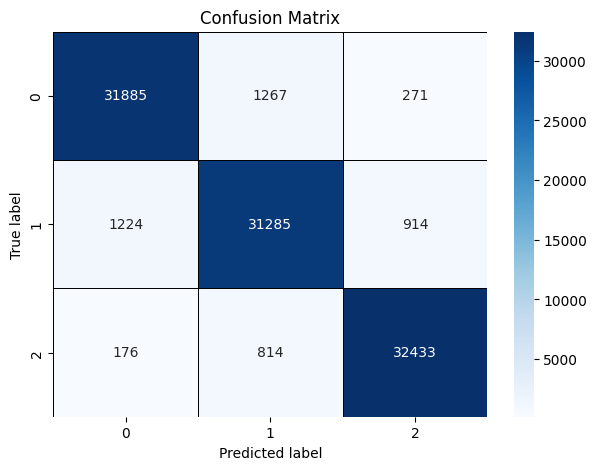

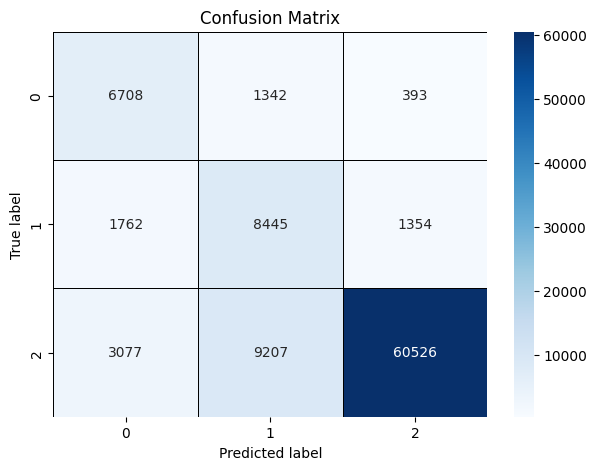

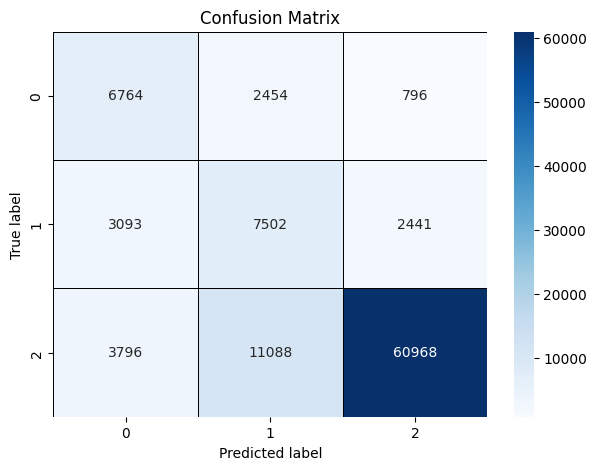

In [23]:
# Get Validation Metrics
print("Train")
train_metrics = get_ml_metrics(lr.transform(df_train_idf))
print("Test")
test_metrics = get_ml_metrics(lr.transform(df_test_idf))
print("OOT")
oot_metrics = get_ml_metrics(lr.transform(df_oot_idf))

##### 3.1.3.2. Logistic Regression CV

K-fold cross validation performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets e.g., with k=3 folds, K-fold cross validation will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. Each fold is used as the test set exactly once. (https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)

With a balanced dataset (df_train_idf) I can random sample because i have same class sizes.

In [ ]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Score",
    maxIter=20,
    regParam=0.1
)

grid = ParamGridBuilder().addGrid(lr.maxIter, [20]).build()

cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=grid,
    evaluator=MulticlassClassificationEvaluator(labelCol="Score", metricName="f1"),
    parallelism=2,
    numFolds=3
)

cv = cv.fit(df_train_idf)

In [35]:
print(f"Avg F1: {cv.avgMetrics[0]:.4f} in 3 times CV on a Train Dataset")

Avg F1: 0.7668 in 3 times CV on a Train Dataset


##### 3.1.3.3. Fit Last Estimator

For the last estimator, I will combine train and test dataset and fit a logistic regression to score OOT.

But i need to undersampling this new dataset again.

In [ ]:
df_full = df_train_idf.unionAll(df_test_idf)
minority_class_sample = df_full.groupBy("Score").count().orderBy("count").limit(1).select("count").collect()[0][0]

In [ ]:
df_sample = undersampling_dataframe(df=df_full, minority_class_sample=minority_class_sample)

In [ ]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Score",
    maxIter=20,
    regParam=0.1
)

lr = lr.fit(df_sample)

In [43]:
lr.write().save("../src/features/logistic_regression.spark")

24/06/06 22:15:48 WARN TaskSetManager: Stage 450 contains a task of very large size (3334 KiB). The maximum recommended task size is 1000 KiB.


## 4.0. Final Estimator Pipeline

In [44]:
from pyspark.ml.classification import LogisticRegressionModel

In [ ]:
artifacts_path = "../src/features"

df_raw = spark.read.format("csv") \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .option("delimiter", ",") \
              .load("../data/Reviews.csv")

df_raw = df_raw.withColumn(
    "Time",
    pf.to_timestamp(pf.from_unixtime("Time"))
)

df_oot = df_raw.filter(
    (pf.year("Time") == 2012) &
    (pf.month("Time") >= 6)
)

In [52]:
df_oot.show(5)

+---+----------+--------------+--------------------+--------------------+----------------------+-----+-------------------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|               Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+-------------------+--------------------+--------------------+
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|2012-09-06 21:00:00|   Not as Advertised|"Product arrived ...|
|  5|B006K2ZZ7K|A1UQRSCLF8GW1T|"Michael D. Bigha...|                   0|                     0|    5|2012-10-20 21:00:00|         Great taffy|Great taffy at a ...|
|  6|B006K2ZZ7K| ADT0SRK1MGOEU|      Twoapennything|                   0|                     0|    4|2012-07-11 21:00:00|          Nice Taffy|I got a wild hair...|
|  7|B006K

### 4.1. Pyspark Pipeline

In [58]:
# Load Stages
tokenizer = Tokenizer(inputCol="Text", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="words")

idf = IDFModel.load(artifacts_path + "/idf.spark")
hashing = HashingTF(inputCol="words", outputCol="raw_features")

estimator = LogisticRegressionModel.load(artifacts_path + "/logistic_regression.spark")

In [60]:
# Custom Stages
noise_score_removal = NoiseLableRemoval(
    inputCol="Text",
    outputCol="Text",
    labelCol="Score"
)

filter_rows_features = FilterRowsFeatures(
    aggCols=['ProductId', 'UserId', 'Score', 'ProfileName', 'Summary', 'Text'],
    keyCol="Id"
)

clean_corpus = CleanCorpus(
    cleanCols=['ProfileName', 'Text', 'Summary']
)

feature_engineering = FeatureEngineering()

In [61]:
# Pipeline Fit & Transform
stages = [
    noise_score_removal,
    filter_rows_features,
    clean_corpus,
    feature_engineering,
    tokenizer,
    stopwords,
    hashing,
    idf,
    estimator
]

pipeline = Pipeline(stages=stages)

pipeline = pipeline.fit(df_oot)

df = pipeline.transform(df_oot)

In [69]:
df_oot_with_probas = df_oot.join(
    df.select(
        pf.col("Id"),
        pf.col("probability"),
        pf.col("prediction")
    ),
    on="Id",
    how="inner"
)

In [73]:
df_oot_with_probas.select(
    pf.col('Id'),
    pf.col('ProductId'),
    pf.col('UserId'),
    pf.col('ProfileName'),
    pf.col('Time'),
    pf.col('Summary'),
    pf.col('probability'),
    pf.col('prediction'),
    pf.col('Score')
).show(truncate=False)

24/06/06 22:32:19 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


+----+----------+--------------+---------------------------------+-------------------+---------------------------------------------+--------------------------------------------------------------+----------+-----+
|Id  |ProductId |UserId        |ProfileName                      |Time               |Summary                                      |probability                                                   |prediction|Score|
+----+----------+--------------+---------------------------------+-------------------+---------------------------------------------+--------------------------------------------------------------+----------+-----+
|53  |B000G6RPMY|A9L6L5H9BPEBO |Edwin C. Pauzer                  |2012-09-28 21:00:00|You'll go nuts over Ass-Kickin' Peanuts.     |[0.10884271600634335,0.017599813397937494,0.8735574705957192] |2.0       |4    |
|78  |B004X2KR36|A26M5O53PHZTKN|"Debs ""peanut"""                |2012-09-20 21:00:00|Taste great                                  |[0.1057766307936

24/06/06 22:32:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
